## Import Required Libraries

In [1]:
import cv2
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from math import ceil
from PIL import Image

## Load Dataset

Option 1 - Load from drive


*   Add *BTP_Dataset* folder from the link below as a shortcut to your *My Drive*

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/BTP_Dataset/unlv_images.zip

Option 2 - Download from https://drive.google.com/drive/folders/14Citi2bfhyQKfDonzcyv4RO9A0bNCJYw?usp=sharing and Upload to Colab Files

In [ ]:
! unzip unlv_images.zip

## Initalize Empty Folders

In [4]:
! mkdir row
! mkdir row/img
! mkdir row/label
! mkdir col
! mkdir col/img
! mkdir col/label

In [5]:
DS = "/content/"
TRAIN_ROW = "/content/row/img/"
TRAIN_COL = "/content/col/img/"
ROW_MASK = "/content/row/label/"
COL_MASK = "/content/col/label/"

## Run script on UNLV

In [6]:
c = 0
read = 0
write = 0

for file in os.listdir(DS + "unlv_xml_gt"):

    if file.endswith(".xml"):
    
        row_file = file.replace(".xml",".png")
        col_file = file.replace(".xml",".png")

        tree = ET.parse(DS + "unlv_xml_gt/" + file) 
        
        # getting the parent tag of the xml document 
        root = tree.getroot()

        doc_file = file.replace(".xml",".png")
        document = cv2.imread(DS + "unlv_images/" + doc_file)

        for elem in root:

            local_r = document.copy()
            local_r[:,:] = 0

            local_c = document.copy()
            local_c[:,:] = 0

            for subelem in elem.findall('Table'):
                table_dict = subelem.attrib
                t_left = int(table_dict['x0'])
                t_right = int(table_dict['x1'])
                t_top = int(table_dict['y0'])
                t_down = int(table_dict['y1'])
                
                local_r[t_top:t_down,t_left:t_right] = 255
                local_c[t_top:t_down,t_left:t_right] = 255

                for subsubelem in subelem.findall('Column'):
                    col_dict = subsubelem.attrib
                    c_left = int(col_dict['x0'])
                    c_right = int(col_dict['x1'])
                    c_top = int(col_dict['y0'])
                    c_down = int(col_dict['y1'])

                    local_c = cv2.line(local_c, (c_left,c_top), (c_right,c_down), (0,0,0), 8) 

                for subsubelem in subelem.findall('Row'):
                    row_dict = subsubelem.attrib
                    r_left = int(row_dict['x0'])
                    r_right = int(row_dict['x1'])
                    r_top = int(row_dict['y0'])
                    r_down = int(row_dict['y1'])
                    
                    local_r = cv2.line(local_r, (r_left,r_top), (r_right,r_down), (0,0,0), 8) 

            # crop the tables from doc
            document = document[t_top:t_down,t_left:t_right]
            local_r = local_r[t_top:t_down,t_left:t_right]
            local_c = local_c[t_top:t_down,t_left:t_right]
            
            # resize to 512x512
            document = cv2.resize(document, (512, 512))
            local_c = cv2.resize(local_c, (512, 512))
            local_r = cv2.resize(local_r, (512, 512))
            
            # Thresholding values below and above 128 to be 0 and 1 respectively
            # To create Mask
            ret, local_r = cv2.threshold(local_r, 128, 1, cv2.THRESH_BINARY)
            ret, local_c = cv2.threshold(local_c, 128, 1, cv2.THRESH_BINARY)
            
            # Save Mask
            cv2.imwrite(TRAIN_ROW + doc_file, document)
            cv2.imwrite(TRAIN_COL + doc_file, document)
            cv2.imwrite(ROW_MASK + row_file, local_r)
            cv2.imwrite(COL_MASK + col_file, local_c)

Sample Output

In [7]:
img = cv2.imread(TRAIN_ROW + "0101_003.png" )
row_label = cv2.imread(ROW_MASK + "0101_003.png" )
col_label = cv2.imread(COL_MASK + "0101_003.png" )

Image 



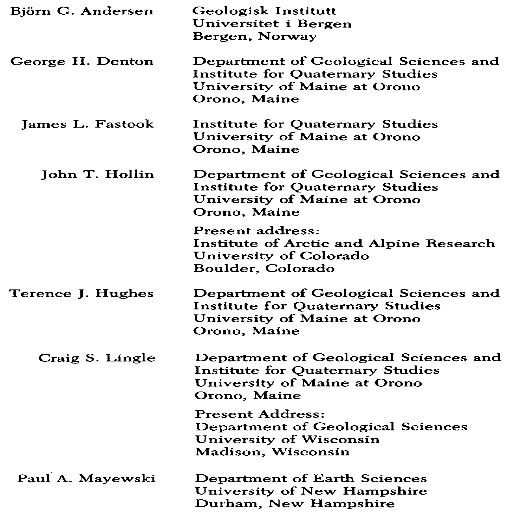

Row Mask 



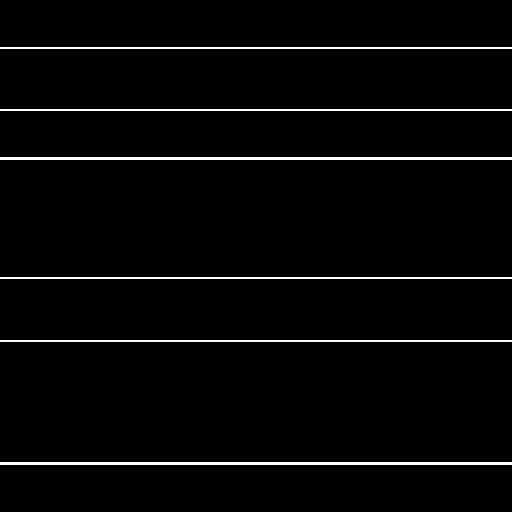

Column Mask 



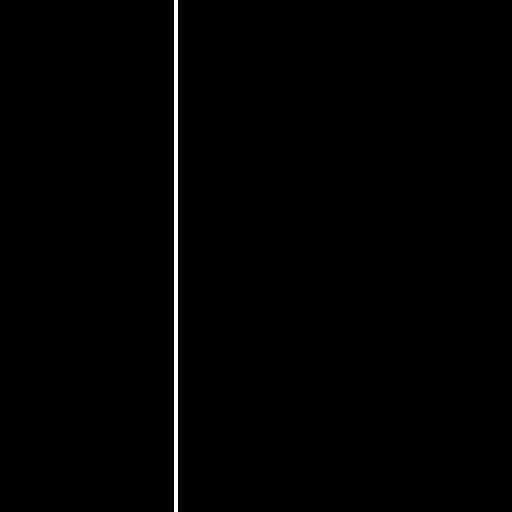

In [8]:
from google.colab.patches import cv2_imshow

img[img==1] = 255
row_label[row_label==0] = 255
col_label[col_label==0] = 255

print("Image \n")
cv2_imshow(img)
print("Row Mask \n")
cv2_imshow(row_label)
print("Column Mask \n")
cv2_imshow(col_label)

## Split folders to generate train and test dataset

In [9]:
!pip install split-folders

In [10]:
import splitfolders

In [11]:
splitfolders.ratio("/content/row", output="/content/row", seed=42, ratio=(.8, .2), group_prefix=None)
splitfolders.ratio("/content/col", output="/content/col", seed=42, ratio=(.8, .2), group_prefix=None)

Copying files: 846 files [00:00, 4220.61 files/s]
Copying files: 846 files [00:00, 4182.48 files/s]


In [12]:
!rm -rf /content/row/img
!rm -rf /content/row/label
!rm -rf /content/col/img
!rm -rf /content/col/label

## Download Processed Data

In [13]:
!zip -r /content/row.zip /content/row

from google.colab import files
files.download("/content/row.zip")

!zip -r /content/col.zip /content/col

from google.colab import files
files.download("/content/col.zip")

  adding: content/row/ (stored 0%)
  adding: content/row/train/ (stored 0%)
  adding: content/row/train/label/ (stored 0%)
  adding: content/row/train/label/5265_137.png (deflated 86%)
  adding: content/row/train/label/1672_069.png (deflated 91%)
  adding: content/row/train/label/1060_195.png (deflated 92%)
  adding: content/row/train/label/5727_091.png (deflated 89%)
  adding: content/row/train/label/0672_278.png (deflated 89%)
  adding: content/row/train/label/9503_027.png (deflated 90%)
  adding: content/row/train/label/5830_462.png (deflated 91%)
  adding: content/row/train/label/9569_024.png (deflated 87%)
  adding: content/row/train/label/5820_160.png (deflated 87%)
  adding: content/row/train/label/9538_012.png (deflated 90%)
  adding: content/row/train/label/5140_040.png (deflated 89%)
  adding: content/row/train/label/5625_007.png (deflated 91%)
  adding: content/row/train/label/9534_058.png (deflated 91%)
  adding: content/row/train/label/8347_056.png (deflated 87%)
  adding:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/col/ (stored 0%)
  adding: content/col/train/ (stored 0%)
  adding: content/col/train/label/ (stored 0%)
  adding: content/col/train/label/5265_137.png (deflated 95%)
  adding: content/col/train/label/1672_069.png (deflated 96%)
  adding: content/col/train/label/1060_195.png (deflated 97%)
  adding: content/col/train/label/5727_091.png (deflated 97%)
  adding: content/col/train/label/0672_278.png (deflated 96%)
  adding: content/col/train/label/9503_027.png (deflated 96%)
  adding: content/col/train/label/5830_462.png (deflated 97%)
  adding: content/col/train/label/9569_024.png (deflated 96%)
  adding: content/col/train/label/5820_160.png (deflated 96%)
  adding: content/col/train/label/9538_012.png (deflated 95%)
  adding: content/col/train/label/5140_040.png (deflated 98%)
  adding: content/col/train/label/5625_007.png (deflated 96%)
  adding: content/col/train/label/9534_058.png (deflated 95%)
  adding: content/col/train/label/8347_056.png (deflated 97%)
  adding:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>